# Detecting garbage by trained model

#### Import trained model

In [1]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("Yolov11m_trained_80_epoch.pt")

# Display model information (optional)
model.info()


YOLO11m summary (fused): 303 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs


(303, 20034658, 0, 67.67150079999999)

#### Function to save detected object by model to a NoSQL Database

#### connecting to mongodb database

Before starting the next cell, you must run the command ```mongod ``` in command prompt, then run ```mongosh``` in another command prompt so mongodb can work  

In [2]:
# Run mongod and mongosh
from pymongo import MongoClient
import datetime
import numpy as np
from bson.binary import Binary

# Run Client
client = MongoClient("localhost", 27017)
db = client['IRS']
collection = db["detections"]  # Collection name


Detecting using cam

In [3]:
import cv2
import time
# Initialize the webcam

# Initialize variables for tracking object detection time
detection_times = []
num_frames_to_track = 5  # Number of frames to track for average time

cap = cv2.VideoCapture(0)  # 0 for default webcam

while cap.isOpened():
    
    start_time = time.time()  # Record start time for frame processing
    
    # Read a frame from the webcam
    success, frame = cap.read()

    if success:
        # Run inference on the frame
        results = model(frame, conf = 0.80)

        # Get the annotated frame with bounding boxes
        annotated_frame = results[0].plot()

        # Record end time for frame processing
        end_time = time.time()  
        
        # Calculate frame processing time
        processing_time = end_time - start_time  

        # Add detection time to list
        detection_times.append(processing_time)  

        # Keep only the last 'num_frames_to_track' times for averaging
        if len(detection_times) > num_frames_to_track:
            detection_times = detection_times[-num_frames_to_track:]
        
        cls = None
        # Show item type scanned
        for r in results:
            for c in r.boxes.cls:
                cls = model.names[int(c)]
        
        
        # Font Settings 
        text_y_position = 30
        font_scale = 0.5  # Reduced font scale for smaller text
        font_thickness = 1  # Reduced thickness (optional)

        # Convert frame to binary for MongoDB storage
        _, buffer = cv2.imencode(".jpg", annotated_frame)
        image_binary = Binary(buffer.tobytes())  # BSON Binary format
        
        # Calculate and display average detection time
        average_detection_time = sum(detection_times) / len(detection_times)
        cv2.putText(annotated_frame, f"Item detected: {cls}", (10, text_y_position),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)
        text_y_position += 20  # Adjust vertical spacing as needed

        # Make a var to check weather the item scanned or not to avoid redundant items
        is_detected = False
        # Save img of item scanned
        if cls != None:
            if not is_detected:
                # Store image & metadata in one document
                detection_data = {
                    "image": image_binary,
                    "detected_item": cls,
                    "timestamp": datetime.datetime.now(),
                    "processing_time": processing_time
                }
                collection.insert_one(detection_data)        
            is_detected = True
        

        # Display the annotated frame
        cv2.imshow("YOLOv11 Object Detection", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        print("Error reading frame from webcam.")
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
client.close()




0: 480x640 (no detections), 1334.8ms
Speed: 11.3ms preprocess, 1334.8ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1612.4ms
Speed: 5.9ms preprocess, 1612.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1307.6ms
Speed: 22.6ms preprocess, 1307.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1546.5ms
Speed: 6.4ms preprocess, 1546.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1382.9ms
Speed: 3.7ms preprocess, 1382.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1087.4ms
Speed: 6.0ms preprocess, 1087.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1283.2ms
Speed: 80.6ms preprocess, 1283.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 1251.4ms


#### Show items stored in the database

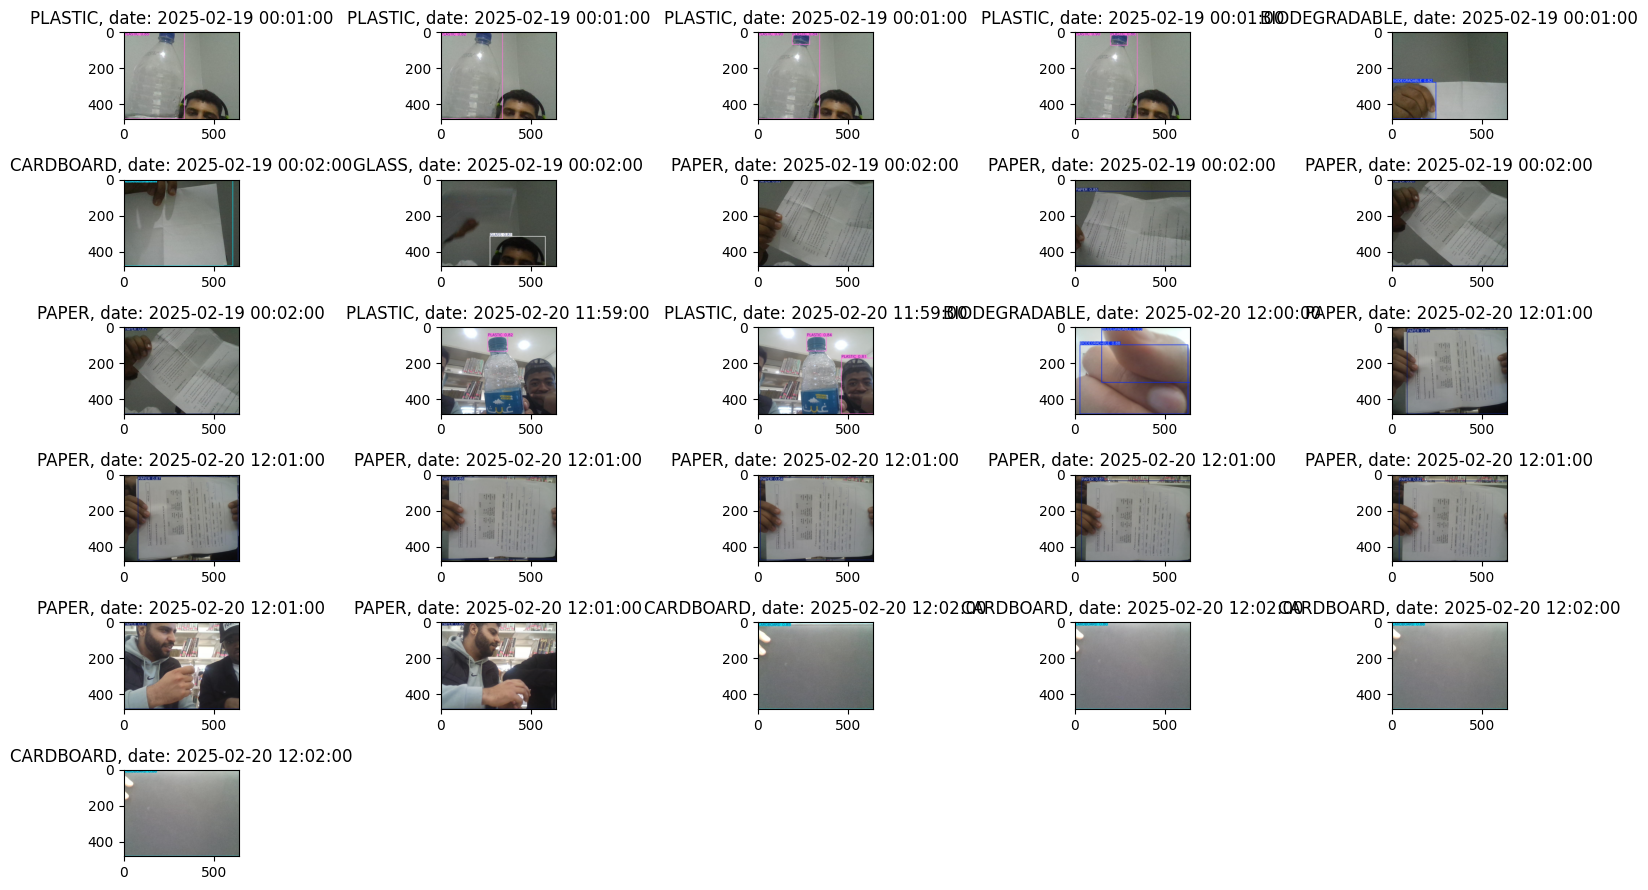

In [ ]:
# Run mongod and mongosh
from pymongo import MongoClient
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io

client = MongoClient("localhost", 27017)
db = client['IRS']
collection = db["detections"]  # Collection name

# Show all images of items stored in database
n = collection.count_documents({})
w = 16
h = 9
fig = plt.figure(figsize=(16, 9))
columns = 5
rows = (n // columns) + (n % columns > 0)

imgs = list(collection.find({}))

for i, img_doc in enumerate(imgs):
    # Print images as grid    
    ax = fig.add_subplot(rows, columns, i + 1)

    img = Image.open(io.BytesIO(img_doc["image"]))
    cls = img_doc["detected_item"]
    tm = img_doc["timestamp"]
    ax.set_title(f"{cls}, date: {tm.replace(second=0, microsecond=0)}")
    ax.imshow(img)
    
plt.tight_layout()
plt.show()

client.close()
